In [4]:
%matplotlib inline
import numpy as np
import networkx as nx
import operator
import matplotlib.pyplot as plt

### ??? 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

from qiskit.aqua.components.optimizers import SPSA, SLSQP, COBYLA

In [5]:
class Graph:
    def __init__(self, n, E, isWeighted = False):
        assert isinstance(n, int), 'n is not an integer: {}'.format(n)
        assert n > 0, 'n is not positive: {}'.format(n)
        self.n = n
        
        edgelist = []
        for edge in E:
            assert isinstance(edge[0], int), 'edge[0] is not an integer: {}'.format(edge[0])
            assert isinstance(edge[1], int), 'edge[1] is not an integer: {}'.format(edge[1])
            assert 0 <= edge[0] < n, 'edge[0] is not in range [0, {}]: {}'.format(edge[0], n-1)
            assert 0 <= edge[1] < n, 'edge[1] is not in range [0, {}]: {}'.format(edge[1], n-1)
            edgelist.append(edge if isWeighted else (edge[0], edge[1], 1.0))
                
        self.E = edgelist
        
        self.V = np.arange(0, n, 1)

        G = nx.Graph()
        G.add_nodes_from(self.V)
        G.add_weighted_edges_from(self.E) # to-do: non-weighted case
            
        self.G = G
        self.isWeighted = isWeighted

    def draw(self, color = 'c', node_size=600, alpha=1, colors=None, cut_edges=None):
        if colors is None:
            colors = [color for node in self.G.nodes()]
        ax = plt.axes(frameon=True)
        pos = nx.spring_layout(self.G)
        
        if self.isWeighted:
            weights = nx.get_edge_attributes(self.G,'weight')
            nx.draw_networkx_edge_labels(self.G,pos,edge_labels=weights)
        nx.draw_networkx(self.G, node_color=colors, node_size=node_size, style='dashed', alpha=alpha,ax=ax, pos=pos)
        
        if cut_edges is not None:
            nx.draw_networkx_edges(self.G, edgelist=cut_edges, style='solid', pos=pos)

In [6]:
def U_B(qc, beta):
    for q in range(qc.n_qubits):
        qc.rx(2 * beta, q)

In [7]:
def U_C(qc, gamma, G):
    for edge in G.E:
        q1 = edge[0]
        q2 = edge[1]
        qc.cx(q1, q2)
        qc.rz(gamma, q2)
        qc.cx(q1, q2)

In [8]:
def expval(H, psi):
    psi_dagger = np.conjugate(psi)
    return np.matmul(np.matmul(psi, H), psi_dagger)

In [21]:
def QAOA(G, gammas, betas, edge=None, qc=None, p=1):
    n = G.n
    if qc is None:
        qr = QuantumRegister(n)
        cr = ClassicalRegister(n)
        qc = QuantumCircuit(qr, cr)

    assert n == qc.n_qubits, 'the circuit\'s number of qubits ({}) \
                                is not equal to |V(G)|=({})'.format(qc.n_qubits, n)
    
    for q in range(n):
        qc.h(q)
        
    for i in range(p):
        U_C(qc, gammas[i], G)
        U_B(qc, betas[i])
    
    if edge is None:
        return qc.measure(range(n), range(n))
    
    
    Z = [[1, 0], [0, -1]]
    Z2 = np.kron(Z, Z)
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    output_state = result.get_statevector(qc)
    print(output_state)
    def ampl_to_probs(c):
        return c.real * c.real + c.imag * c.imag
        
    amplitudes_2_n = list(map(ampl_to_probs, output_state))
    print(amplitudes_2_n)
    amplitudes_n = [0] * 4
    
    def bin_str(k):
        return ("{0:0" + str(n) + "b}").format(k)

    bin_strings = list(map(bin_str, range(0, len(amplitudes_2_n))))
    q1 = edge[0]
    q2 = edge[1]
    
    for bin_string in bin_strings:
        
        if ((bin_string[q1] == '0') and (bin_string[q2] == '0')):
            amplitudes_n[0] += amplitudes_2_n[int(bin_string, 2)]
        elif ((bin_string[q1] == '0') and (bin_string[q2] == '1')):
            amplitudes_n[1] += amplitudes_2_n[int(bin_string, 2)]
        elif ((bin_string[q1] == '1') and (bin_string[q2] == '0')): 
            amplitudes_n[2] += amplitudes_2_n[int(bin_string, 2)]
        else:
            amplitudes_n[3] += amplitudes_2_n[int(bin_string, 2)]

    print(amplitudes_n)
    # during the optimization phase we are evaluating a term in the objective
    return expval(Z2, amplitudes_n)

In [22]:
def maxcut(G, lower_bound=-np.pi, upper_bound=np.pi, step_size=0.1,
           maxiter=100, tol=0.0001, shots=1024, p=1, is_numerical=True, plot_most_freq_bits=True):
    print("\nNumber of layers: {:d}".format(p))
    def objective(params):
        cost = 0
        gammas = [params[0]] if p == 1 else params[:p]
        betas = [params[1]] if p == 1 else params[p:]
        for edge in G.E:
            expval = 1 - QAOA(G, gammas, betas, edge=edge, p=p)
            cost -= 0.5 * expval * (edge[2] if G.isWeighted else 1)
        return cost
    
    def plot_hist(counts, color='lightpink'):
        sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1])}
        most_freq_bits = sorted_counts if len(sorted_counts) <= 30 else list(sorted_counts)[len(sorted_counts)-30:]
        plt.bar(most_freq_bits, [counts[bit] for bit in most_freq_bits], color=color)
        _, _ = plt.xticks(rotation=80)
        plt.show()
    
    if is_numerical: #implement non-numerical
        initial_params = 0.01 * np.random.rand(2 * p)
        optimizer = COBYLA(maxiter=maxiter, tol=tol)
        minimizers, min_cost, _ = optimizer.optimize(num_vars=2*p,
                                                     objective_function=objective,
                                                     initial_point=initial_params)
        
        
        opt_gammas = [minimizers[0]] if p == 1 else minimizers[:p]
        opt_betas = [minimizers[1]] if p == 1 else minimizers[p:]      
        
    print('Minimal expectation value: {}'.format(min_cost))
    print('Optimal parameters: \nγ = {}, \nβ = {}'.format(opt_gammas, opt_betas))
    
    # to do: real hardware
    qr = QuantumRegister(G.n)
    cr = ClassicalRegister(G.n)
    qc = QuantumCircuit(qr, cr)
    QAOA(G, opt_gammas, opt_betas, qc=qc, p=p)
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    most_freq_bit = max(counts.items(), key=operator.itemgetter(1))[0]
    
    if plot_most_freq_bits:
        print('\nHistogram of the most frequent bits:')
        plot_hist(counts)
        
    print('\nMost frequently sampled bit string is: {}'.format(most_freq_bit))
    
    cut_edges = []
    for edge in G.E:
        if most_freq_bit[edge[0]] != most_freq_bit[edge[1]]:
            cut_edges.append(edge)
    g.draw(colors=['r' if bit == '0' else 'c' for bit in most_freq_bit], cut_edges=cut_edges)
    
    
    return min_cost, counts, most_freq_bit

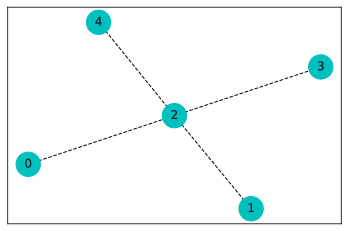

In [23]:
E = [(0, 2), (1, 2), (2, 3), (2, 4)]

g = Graph(5, E, isWeighted=False)
g.draw()


Number of layers: 2
[0.17662781-0.00798781j 0.17665253-0.007034j   0.17665253-0.007034j
 0.1766721 -0.00608011j 0.1766958 -0.00417221j 0.17668653-0.00512617j
 0.17668653-0.00512617j 0.1766721 -0.00608011j 0.17665253-0.007034j
 0.1766721 -0.00608011j 0.1766721 -0.00608011j 0.17668653-0.00512617j
 0.17668653-0.00512617j 0.1766721 -0.00608011j 0.1766721 -0.00608011j
 0.17665253-0.007034j   0.17665253-0.007034j   0.1766721 -0.00608011j
 0.1766721 -0.00608011j 0.17668653-0.00512617j 0.17668653-0.00512617j
 0.1766721 -0.00608011j 0.1766721 -0.00608011j 0.17665253-0.007034j
 0.1766721 -0.00608011j 0.17668653-0.00512617j 0.17668653-0.00512617j
 0.1766958 -0.00417221j 0.1766721 -0.00608011j 0.17665253-0.007034j
 0.17665253-0.007034j   0.17662781-0.00798781j]
[0.0312611884928289, 0.0312555940759921, 0.0312555940759921, 0.031249999849469287, 0.0312388124103545, 0.03124440592400812, 0.03124440592400813, 0.031249999849469256, 0.031255594075992085, 0.031249999849469294, 0.031249999849469266, 0.0312

[ 0.17705512-0.00745644j  0.10117212+0.14547412j  0.10117212+0.14547412j
 -0.06826207+0.16306482j -0.11797675-0.131066j   -0.17388273+0.02943257j
 -0.17388273+0.02943257j -0.06826207+0.16306482j  0.10117212+0.14547412j
 -0.06826207+0.16306482j -0.06826207+0.16306482j -0.17388273+0.02943257j
 -0.17388273+0.02943257j -0.06826207+0.16306482j -0.06826207+0.16306482j
  0.10117212+0.14547412j  0.10117212+0.14547412j -0.06826207+0.16306482j
 -0.06826207+0.16306482j -0.17388273+0.02943257j -0.17388273+0.02943257j
 -0.06826207+0.16306482j -0.06826207+0.16306482j  0.10117212+0.14547412j
 -0.06826207+0.16306482j -0.17388273+0.02943257j -0.17388273+0.02943257j
 -0.11797675-0.131066j   -0.06826207+0.16306482j  0.10117212+0.14547412j
  0.10117212+0.14547412j  0.17705512-0.00745644j]
[0.03140411385800604, 0.03139851878433497, 0.031398518784334944, 0.031249845820581164, 0.03109681121977436, 0.03110148121534817, 0.031101481215348187, 0.03124984582058115, 0.03139851878433496, 0.031249845820581153, 0.031

[-0.14534154+0.10042445j -0.14513689+0.10081728j -0.14513689+0.10081728j
 -0.14493268+0.10121264j -0.14452555+0.10201098j -0.14472891+0.10161054j
 -0.14472891+0.10161054j -0.14493268+0.10121264j -0.14513689+0.10081728j
 -0.14493268+0.10121264j -0.14493268+0.10121264j -0.14472891+0.10161054j
 -0.14472891+0.10161054j -0.14493268+0.10121264j -0.14493268+0.10121264j
 -0.14513689+0.10081728j -0.14513689+0.10081728j -0.14493268+0.10121264j
 -0.14493268+0.10121264j -0.14472891+0.10161054j -0.14472891+0.10161054j
 -0.14493268+0.10121264j -0.14493268+0.10121264j -0.14513689+0.10081728j
 -0.14493268+0.10121264j -0.14472891+0.10161054j -0.14472891+0.10161054j
 -0.14452555+0.10201098j -0.14493268+0.10121264j -0.14513689+0.10081728j
 -0.14513689+0.10081728j -0.14534154+0.10042445j]
[0.031209233698433318, 0.031228841680767443, 0.031228841680767453, 0.031249481960143315, 0.03129387459632316, 0.03127115830532844, 0.03127115830532842, 0.031249481960143308, 0.03122884168076747, 0.031249481960143304, 0.0

[-0.15103305-0.0443815j  -0.10065415+0.04595233j -0.10065415+0.04595233j
 -0.07676213+0.12126399j -0.1671119 +0.28732867j -0.09232153+0.19880035j
 -0.09232153+0.19880035j -0.07676213+0.12126399j -0.10065415+0.04595233j
 -0.07676213+0.12126399j -0.07676213+0.12126399j -0.09232153+0.19880035j
 -0.09232153+0.19880035j -0.07676213+0.12126399j -0.07676213+0.12126399j
 -0.10065415+0.04595233j -0.10065415+0.04595233j -0.07676213+0.12126399j
 -0.07676213+0.12126399j -0.09232153+0.19880035j -0.09232153+0.19880035j
 -0.07676213+0.12126399j -0.07676213+0.12126399j -0.10065415+0.04595233j
 -0.07676213+0.12126399j -0.09232153+0.19880035j -0.09232153+0.19880035j
 -0.1671119 +0.28732867j -0.07676213+0.12126399j -0.10065415+0.04595233j
 -0.10065415+0.04595233j -0.15103305-0.0443815j ]
[0.02478069866425498, 0.012242873926278819, 0.012242873926278803, 0.020597379316054248, 0.11048414826607075, 0.048044845367058456, 0.048044845367058414, 0.020597379316054258, 0.012242873926278819, 0.020597379316054227, 0

[ 0.1808523 -0.25859663j -0.0165989 -0.07980305j -0.0165989 -0.07980305j
 -0.04907992+0.0242406j  -0.41741656-0.27852189j -0.15760721+0.03425711j
 -0.15760721+0.03425711j -0.04907992+0.0242406j  -0.0165989 -0.07980305j
 -0.04907992+0.0242406j  -0.04907992+0.0242406j  -0.15760721+0.03425711j
 -0.15760721+0.03425711j -0.04907992+0.0242406j  -0.04907992+0.0242406j
 -0.0165989 -0.07980305j -0.0165989 -0.07980305j -0.04907992+0.0242406j
 -0.04907992+0.0242406j  -0.15760721+0.03425711j -0.15760721+0.03425711j
 -0.04907992+0.0242406j  -0.04907992+0.0242406j  -0.0165989 -0.07980305j
 -0.04907992+0.0242406j  -0.15760721+0.03425711j -0.15760721+0.03425711j
 -0.41741656-0.27852189j -0.04907992+0.0242406j  -0.0165989 -0.07980305j
 -0.0165989 -0.07980305j  0.1808523 -0.25859663j]
[0.09957976853952911, 0.006644050510128748, 0.006644050510128744, 0.002996445601075057, 0.25181102537623073, 0.026013582609318835, 0.026013582609318835, 0.0029964456010750542, 0.006644050510128741, 0.002996445601075051, 0.

[ 0.26425761-0.25494124j  0.20884044+0.08951767j  0.20884044+0.08951767j
  0.04757695+0.01814522j -0.21885868+0.05789861j -0.11407906-0.09974657j
 -0.11407906-0.09974657j  0.04757695+0.01814522j  0.20884044+0.08951767j
  0.04757695+0.01814522j  0.04757695+0.01814522j -0.11407906-0.09974657j
 -0.11407906-0.09974657j  0.04757695+0.01814522j  0.04757695+0.01814522j
  0.20884044+0.08951767j  0.20884044+0.08951767j  0.04757695+0.01814522j
  0.04757695+0.01814522j -0.11407906-0.09974657j -0.11407906-0.09974657j
  0.04757695+0.01814522j  0.04757695+0.01814522j  0.20884044+0.08951767j
  0.04757695+0.01814522j -0.11407906-0.09974657j -0.11407906-0.09974657j
 -0.21885868+0.05789861j  0.04757695+0.01814522j  0.20884044+0.08951767j
  0.20884044+0.08951767j  0.26425761-0.25494124j]
[0.1348271232216804, 0.05162774259764011, 0.0516277425976401, 0.0025928147824063755, 0.05125137188281675, 0.022963411452626217, 0.02296341145262621, 0.002592814782406377, 0.051627742597640094, 0.002592814782406379, 0.002

[ 0.02905203-0.28583594j -0.05900997-0.05466915j -0.05900997-0.05466915j
 -0.06053873+0.04970088j -0.46561204+0.04930971j -0.15566823+0.09823838j
 -0.15566823+0.09823838j -0.06053873+0.04970088j -0.05900997-0.05466915j
 -0.06053873+0.04970088j -0.06053873+0.04970088j -0.15566823+0.09823838j
 -0.15566823+0.09823838j -0.06053873+0.04970088j -0.06053873+0.04970088j
 -0.05900997-0.05466915j -0.05900997-0.05466915j -0.06053873+0.04970088j
 -0.06053873+0.04970088j -0.15566823+0.09823838j -0.15566823+0.09823838j
 -0.06053873+0.04970088j -0.06053873+0.04970088j -0.05900997-0.05466915j
 -0.06053873+0.04970088j -0.15566823+0.09823838j -0.15566823+0.09823838j
 -0.46561204+0.04930971j -0.06053873+0.04970088j -0.05900997-0.05466915j
 -0.05900997-0.05466915j  0.02905203-0.28583594j]
[0.0825462066053221, 0.006470891998340909, 0.006470891998340906, 0.006135116154674435, 0.21922602371379363, 0.03388337618986859, 0.033883376189868586, 0.006135116154674445, 0.006470891998340904, 0.006135116154674439, 0.0

 -0.04560318-0.06246391j  0.12460703-0.3182095j ]
[0.11678419683320165, 0.005981389752242902, 0.0059813897522429, 0.0028446360693598566, 0.25279098347207557, 0.022357861067397934, 0.02235786106739792, 0.0028446360693598497, 0.005981389752242898, 0.0028446360693598557, 0.002844636069359854, 0.022357861067397906, 0.022357861067397927, 0.00284463606935985, 0.002844636069359851, 0.005981389752242887, 0.0059813897522429, 0.002844636069359852, 0.0028446360693598475, 0.022357861067397906, 0.022357861067397934, 0.002844636069359853, 0.0028446360693598557, 0.0059813897522428845, 0.002844636069359852, 0.022357861067397924, 0.022357861067397917, 0.2527909834720757, 0.0028446360693598514, 0.005981389752242891, 0.005981389752242885, 0.11678419683320171]
[0.16562013536540784, 0.33437986463459185, 0.3343798646345919, 0.16562013536540787]
[ 0.12460703-0.3182095j  -0.04560318-0.06246391j -0.04560318-0.06246391j
 -0.04707094+0.02507913j -0.50099351+0.04238499j -0.13730354+0.0592081j
 -0.13730354+0.05920

[ 0.00718177-0.1701261j  -0.02664609-0.00915215j -0.02664609-0.00915215j
  0.00138534+0.12216503j -0.37107516+0.18366287j -0.08436572+0.21117174j
 -0.08436572+0.21117174j  0.00138534+0.12216503j -0.02664609-0.00915215j
  0.00138534+0.12216503j  0.00138534+0.12216503j -0.08436572+0.21117174j
 -0.08436572+0.21117174j  0.00138534+0.12216503j  0.00138534+0.12216503j
 -0.02664609-0.00915215j -0.02664609-0.00915215j  0.00138534+0.12216503j
  0.00138534+0.12216503j -0.08436572+0.21117174j -0.08436572+0.21117174j
  0.00138534+0.12216503j  0.00138534+0.12216503j -0.02664609-0.00915215j
  0.00138534+0.12216503j -0.08436572+0.21117174j -0.08436572+0.21117174j
 -0.37107516+0.18366287j  0.00138534+0.12216503j -0.02664609-0.00915215j
 -0.02664609-0.00915215j  0.00718177-0.1701261j ]
[0.0289944679764616, 0.0007937762374626057, 0.000793776237462608, 0.014926214934384558, 0.17142882578019622, 0.05171107792179608, 0.05171107792179608, 0.014926214934384575, 0.0007937762374626088, 0.014926214934384554, 0.

 -0.02532797-0.01314909j  0.01309099-0.17319176j]
[0.03016676091893017, 0.0008144048032926526, 0.0008144048032926519, 0.014590875938697455, 0.1716393666973807, 0.05184774938458332, 0.05184774938458333, 0.014590875938697468, 0.0008144048032926517, 0.014590875938697428, 0.014590875938697455, 0.05184774938458333, 0.05184774938458335, 0.014590875938697468, 0.014590875938697458, 0.0008144048032926467, 0.0008144048032926538, 0.014590875938697437, 0.014590875938697437, 0.05184774938458333, 0.05184774938458335, 0.014590875938697461, 0.014590875938697461, 0.0008144048032926461, 0.01459087593869744, 0.05184774938458331, 0.05184774938458333, 0.1716393666973807, 0.014590875938697458, 0.0008144048032926482, 0.0008144048032926482, 0.03016676091893018]
[0.12823035252948378, 0.3717696474705157, 0.37176964747051566, 0.12823035252948384]
[ 0.01309099-0.17319176j -0.02532797-0.01314909j -0.02532797-0.01314909j
 -0.00270907+0.12076232j -0.38540982+0.15198236j -0.09559663+0.20666164j
 -0.09559663+0.2066616

[ 7.89808111e-03-0.14504704j  2.86356759e-04-0.00618871j
  2.86356759e-04-0.00618871j  2.48471114e-02+0.13328386j
 -3.40767295e-01+0.16656677j -7.18174267e-02+0.22580735j
 -7.18174267e-02+0.22580735j  2.48471114e-02+0.13328386j
  2.86356759e-04-0.00618871j  2.48471114e-02+0.13328386j
  2.48471114e-02+0.13328386j -7.18174267e-02+0.22580735j
 -7.18174267e-02+0.22580735j  2.48471114e-02+0.13328386j
  2.48471114e-02+0.13328386j  2.86356759e-04-0.00618871j
  2.86356759e-04-0.00618871j  2.48471114e-02+0.13328386j
  2.48471114e-02+0.13328386j -7.18174267e-02+0.22580735j
 -7.18174267e-02+0.22580735j  2.48471114e-02+0.13328386j
  2.48471114e-02+0.13328386j  2.86356759e-04-0.00618871j
  2.48471114e-02+0.13328386j -7.18174267e-02+0.22580735j
 -7.18174267e-02+0.22580735j -3.40767295e-01+0.16656677j
  2.48471114e-02+0.13328386j  2.86356759e-04-0.00618871j
  2.86356759e-04-0.00618871j  7.89808111e-03-0.14504704j]
[0.021101023875862136, 3.8382095212942815e-05, 3.838209521294264e-05, 0.018381966504745

[ 0.00735099-0.16778608j -0.02436507-0.00899966j -0.02436507-0.00899966j
  0.00246447+0.12330044j -0.37156707+0.17612793j -0.08584936+0.21170567j
 -0.08584936+0.21170567j  0.00246447+0.12330044j -0.02436507-0.00899966j
  0.00246447+0.12330044j  0.00246447+0.12330044j -0.08584936+0.21170567j
 -0.08584936+0.21170567j  0.00246447+0.12330044j  0.00246447+0.12330044j
 -0.02436507-0.00899966j -0.02436507-0.00899966j  0.00246447+0.12330044j
  0.00246447+0.12330044j -0.08584936+0.21170567j -0.08584936+0.21170567j
  0.00246447+0.12330044j  0.00246447+0.12330044j -0.02436507-0.00899966j
  0.00246447+0.12330044j -0.08584936+0.21170567j -0.08584936+0.21170567j
 -0.37156707+0.17612793j  0.00246447+0.12330044j -0.02436507-0.00899966j
 -0.02436507-0.00899966j  0.00735099-0.16778608j]
[0.028206207200831484, 0.0006746504616387064, 0.0006746504616387059, 0.015209072692965536, 0.16908313778215645, 0.05218940425316599, 0.05218940425316597, 0.015209072692965547, 0.0006746504616387059, 0.015209072692965533,

[ 0.00793962-0.16208478j -0.02018608-0.00734279j -0.02018608-0.00734279j
  0.01055463+0.12562952j -0.35657205+0.19449153j -0.07354537+0.21785808j
 -0.07354537+0.21785808j  0.01055463+0.12562952j -0.02018608-0.00734279j
  0.01055463+0.12562952j  0.01055463+0.12562952j -0.07354537+0.21785808j
 -0.07354537+0.21785808j  0.01055463+0.12562952j  0.01055463+0.12562952j
 -0.02018608-0.00734279j -0.02018608-0.00734279j  0.01055463+0.12562952j
  0.01055463+0.12562952j -0.07354537+0.21785808j -0.07354537+0.21785808j
  0.01055463+0.12562952j  0.01055463+0.12562952j -0.02018608-0.00734279j
  0.01055463+0.12562952j -0.07354537+0.21785808j -0.07354537+0.21785808j
 -0.35657205+0.19449153j  0.01055463+0.12562952j -0.02018608-0.00734279j
 -0.02018608-0.00734279j  0.00793962-0.16208478j]
[0.026334512584151096, 0.0004613942049987155, 0.0004613942049987153, 0.015894177142547396, 0.16497058358010713, 0.0528710660401156, 0.0528710660401156, 0.01589417714254741, 0.0004613942049987149, 0.0158941771425474, 0.01

 -0.03281352-0.01299772j  0.01107486-0.18032295j]
[0.03263901788583752, 0.0012456677450515292, 0.0012456677450515337, 0.013768721593339962, 0.17961906985937037, 0.050036727928636573, 0.050036727928636615, 0.01376872159333996, 0.0012456677450515309, 0.013768721593339953, 0.013768721593339953, 0.05003672792863662, 0.050036727928636573, 0.013768721593339948, 0.013768721593339953, 0.0012456677450515246, 0.0012456677450515305, 0.013768721593339946, 0.013768721593339939, 0.05003672792863659, 0.050036727928636615, 0.013768721593339953, 0.013768721593339967, 0.0012456677450515237, 0.013768721593339939, 0.050036727928636573, 0.050036727928636573, 0.1796190698593705, 0.013768721593339955, 0.0012456677450515257, 0.0012456677450515283, 0.03263901788583755]
[0.12771891382964856, 0.3722810861703516, 0.3722810861703516, 0.12771891382964856]
[ 0.01107486-0.18032295j -0.03281352-0.01299772j -0.03281352-0.01299772j
 -0.00707654+0.11712662j -0.38814565+0.17018232j -0.09437775+0.20280426j
 -0.09437775+0.2

[ 0.0084595 -0.17734432j -0.03238153-0.0107767j  -0.03238153-0.0107767j
 -0.00371486+0.11859411j -0.3786089 +0.18715715j -0.08740045+0.20641014j
 -0.08740045+0.20641014j -0.00371486+0.11859411j -0.03238153-0.0107767j
 -0.00371486+0.11859411j -0.00371486+0.11859411j -0.08740045+0.20641014j
 -0.08740045+0.20641014j -0.00371486+0.11859411j -0.00371486+0.11859411j
 -0.03238153-0.0107767j  -0.03238153-0.0107767j  -0.00371486+0.11859411j
 -0.00371486+0.11859411j -0.08740045+0.20641014j -0.08740045+0.20641014j
 -0.00371486+0.11859411j -0.00371486+0.11859411j -0.03238153-0.0107767j
 -0.00371486+0.11859411j -0.08740045+0.20641014j -0.08740045+0.20641014j
 -0.3786089 +0.18715715j -0.00371486+0.11859411j -0.03238153-0.0107767j
 -0.03238153-0.0107767j   0.0084595 -0.17734432j]
[0.0315225722691375, 0.0011647010614707655, 0.001164701061470767, 0.014078364280014981, 0.1783725032218968, 0.0502439836457481, 0.05024398364574812, 0.014078364280015002, 0.0011647010614707666, 0.014078364280014978, 0.014078

[ 0.01103685-0.17619562j -0.03107337-0.01119842j -0.03107337-0.01119842j
 -0.00193379+0.11904897j -0.37880632+0.18591296j -0.08604202+0.20720781j
 -0.08604202+0.20720781j -0.00193379+0.11904897j -0.03107337-0.01119842j
 -0.00193379+0.11904897j -0.00193379+0.11904897j -0.08604202+0.20720781j
 -0.08604202+0.20720781j -0.00193379+0.11904897j -0.00193379+0.11904897j
 -0.03107337-0.01119842j -0.03107337-0.01119842j -0.00193379+0.11904897j
 -0.00193379+0.11904897j -0.08604202+0.20720781j -0.08604202+0.20720781j
 -0.00193379+0.11904897j -0.00193379+0.11904897j -0.03107337-0.01119842j
 -0.00193379+0.11904897j -0.08604202+0.20720781j -0.08604202+0.20720781j
 -0.37880632+0.18591296j -0.00193379+0.11904897j -0.03107337-0.01119842j
 -0.03107337-0.01119842j  0.01103685-0.17619562j]
[0.03116670735499737, 0.0010909589112763874, 0.0010909589112763865, 0.014176396747511694, 0.1780578526481392, 0.050338305966671854, 0.05033830596667183, 0.014176396747511706, 0.0010909589112763887, 0.01417639674751169, 0

[ 0.01623077-0.17823034j -0.03124871-0.01333226j -0.03124871-0.01333226j
 -0.00250917+0.11784845j -0.38503242+0.17900312j -0.08775489+0.20548144j
 -0.08775489+0.20548144j -0.00250917+0.11784845j -0.03124871-0.01333226j
 -0.00250917+0.11784845j -0.00250917+0.11784845j -0.08775489+0.20548144j
 -0.08775489+0.20548144j -0.00250917+0.11784845j -0.00250917+0.11784845j
 -0.03124871-0.01333226j -0.03124871-0.01333226j -0.00250917+0.11784845j
 -0.00250917+0.11784845j -0.08775489+0.20548144j -0.08775489+0.20548144j
 -0.00250917+0.11784845j -0.00250917+0.11784845j -0.03124871-0.01333226j
 -0.00250917+0.11784845j -0.08775489+0.20548144j -0.08775489+0.20548144j
 -0.38503242+0.17900312j -0.00250917+0.11784845j -0.03124871-0.01333226j
 -0.03124871-0.01333226j  0.01623077-0.17823034j]
[0.032029491268272224, 0.0011542311487298354, 0.0011542311487298348, 0.01389455387832579, 0.18029208533098084, 0.049923543883968205, 0.04992354388396821, 0.013894553878325815, 0.0011542311487298357, 0.013894553878325779,

[ 0.02377227-0.17724627j -0.02858719-0.01588504j -0.02858719-0.01588504j
 -0.00113986+0.11791457j -0.39229769+0.16244379j -0.09025705+0.20459638j
 -0.09025705+0.20459638j -0.00113986+0.11791457j -0.02858719-0.01588504j
 -0.00113986+0.11791457j -0.00113986+0.11791457j -0.09025705+0.20459638j
 -0.09025705+0.20459638j -0.00113986+0.11791457j -0.00113986+0.11791457j
 -0.02858719-0.01588504j -0.02858719-0.01588504j -0.00113986+0.11791457j
 -0.00113986+0.11791457j -0.09025705+0.20459638j -0.09025705+0.20459638j
 -0.00113986+0.11791457j -0.00113986+0.11791457j -0.02858719-0.01588504j
 -0.00113986+0.11791457j -0.09025705+0.20459638j -0.09025705+0.20459638j
 -0.39229769+0.16244379j -0.00113986+0.11791457j -0.02858719-0.01588504j
 -0.02858719-0.01588504j  0.02377227-0.17724627j]
[0.0319813593443442, 0.0010695618428833466, 0.0010695618428833442, 0.013905145866128545, 0.1802854607276566, 0.050006014339923535, 0.05000601433992351, 0.013905145866128565, 0.0010695618428833444, 0.013905145866128536, 0

[ 0.02700654-0.18187106j -0.03214237-0.01736364j -0.03214237-0.01736364j
 -0.00385667+0.11519482j -0.39855023+0.16459942j -0.09152947+0.20106025j
 -0.09152947+0.20106025j -0.00385667+0.11519482j -0.03214237-0.01736364j
 -0.00385667+0.11519482j -0.00385667+0.11519482j -0.09152947+0.20106025j
 -0.09152947+0.20106025j -0.00385667+0.11519482j -0.00385667+0.11519482j
 -0.03214237-0.01736364j -0.03214237-0.01736364j -0.00385667+0.11519482j
 -0.00385667+0.11519482j -0.09152947+0.20106025j -0.09152947+0.20106025j
 -0.00385667+0.11519482j -0.00385667+0.11519482j -0.03214237-0.01736364j
 -0.00385667+0.11519482j -0.09152947+0.20106025j -0.09152947+0.20106025j
 -0.39855023+0.16459942j -0.00385667+0.11519482j -0.03214237-0.01736364j
 -0.03214237-0.01736364j  0.02700654-0.18187106j]
[0.033806435483294796, 0.001334628008417187, 0.001334628008417186, 0.013284720729579685, 0.1859352591691716, 0.048802867234096645, 0.04880286723409665, 0.013284720729579669, 0.0013346280084171865, 0.013284720729579673, 0

[ 0.03083202-0.18478881j -0.03433591-0.01866432j -0.03433591-0.01866432j
 -0.0048021 +0.11319041j -0.40213531+0.16904865j -0.09071565+0.19910732j
 -0.09071565+0.19910732j -0.0048021 +0.11319041j -0.03433591-0.01866432j
 -0.0048021 +0.11319041j -0.0048021 +0.11319041j -0.09071565+0.19910732j
 -0.09071565+0.19910732j -0.0048021 +0.11319041j -0.0048021 +0.11319041j
 -0.03433591-0.01866432j -0.03433591-0.01866432j -0.0048021 +0.11319041j
 -0.0048021 +0.11319041j -0.09071565+0.19910732j -0.09071565+0.19910732j
 -0.0048021 +0.11319041j -0.0048021 +0.11319041j -0.03433591-0.01866432j
 -0.0048021 +0.11319041j -0.09071565+0.19910732j -0.09071565+0.19910732j
 -0.40213531+0.16904865j -0.0048021 +0.11319041j -0.03433591-0.01866432j
 -0.03433591-0.01866432j  0.03083202-0.18478881j]
[0.03509751710655165, 0.0015273114158705294, 0.001527311415870528, 0.012835128739688563, 0.19029025348866657, 0.047873052825792115, 0.04787305282579212, 0.01283512873968859, 0.0015273114158705268, 0.012835128739688572, 0

[ 0.03619446-0.18425846j -0.03377271-0.0200584j  -0.03377271-0.0200584j
 -0.00328316+0.11269869j -0.404239  +0.16897636j -0.08883398+0.19922871j
 -0.08883398+0.19922871j -0.00328316+0.11269869j -0.03377271-0.0200584j
 -0.00328316+0.11269869j -0.00328316+0.11269869j -0.08883398+0.19922871j
 -0.08883398+0.19922871j -0.00328316+0.11269869j -0.00328316+0.11269869j
 -0.03377271-0.0200584j  -0.03377271-0.0200584j  -0.00328316+0.11269869j
 -0.00328316+0.11269869j -0.08883398+0.19922871j -0.08883398+0.19922871j
 -0.00328316+0.11269869j -0.00328316+0.11269869j -0.03377271-0.0200584j
 -0.00328316+0.11269869j -0.08883398+0.19922871j -0.08883398+0.19922871j
 -0.404239  +0.16897636j -0.00328316+0.11269869j -0.03377271-0.0200584j
 -0.03377271-0.0200584j   0.03619446-0.18425846j]
[0.035261220054337634, 0.0015429351417618766, 0.0015429351417618727, 0.012711774158628723, 0.19196217554273248, 0.0475835547210275, 0.04758355472102746, 0.012711774158628734, 0.0015429351417618731, 0.012711774158628725, 0.01

[ 0.03948131-0.17982945j -0.031234  -0.02013751j -0.031234  -0.02013751j
  0.00124149+0.114146j   -0.40040096+0.17380115j -0.08350519+0.20246786j
 -0.08350519+0.20246786j  0.00124149+0.114146j   -0.031234  -0.02013751j
  0.00124149+0.114146j    0.00124149+0.114146j   -0.08350519+0.20246786j
 -0.08350519+0.20246786j  0.00124149+0.114146j    0.00124149+0.114146j
 -0.031234  -0.02013751j -0.031234  -0.02013751j  0.00124149+0.114146j
  0.00124149+0.114146j   -0.08350519+0.20246786j -0.08350519+0.20246786j
  0.00124149+0.114146j    0.00124149+0.114146j   -0.031234  -0.02013751j
  0.00124149+0.114146j   -0.08350519+0.20246786j -0.08350519+0.20246786j
 -0.40040096+0.17380115j  0.00124149+0.114146j   -0.031234  -0.02013751j
 -0.031234  -0.02013751j  0.03948131-0.17982945j]
[0.0338974057259386, 0.0013810819613368584, 0.0013810819613368605, 0.013030850359765016, 0.19052776997300955, 0.047966348574278526, 0.047966348574278526, 0.013030850359765016, 0.0013810819613368592, 0.01303085035976501, 0.01

 -0.03033937-0.02210512j  0.04526499-0.17920331j]
[0.03416274595706603, 0.0014091138133756798, 0.0014091138133756793, 0.012900464015654643, 0.19192250884069348, 0.04771887646370243, 0.04771887646370241, 0.012900464015654659, 0.0014091138133756798, 0.01290046401565463, 0.012900464015654629, 0.0477188764637024, 0.047718876463702424, 0.012900464015654643, 0.012900464015654646, 0.0014091138133756733, 0.0014091138133756778, 0.012900464015654636, 0.012900464015654626, 0.04771887646370242, 0.047718876463702396, 0.012900464015654638, 0.01290046401565464, 0.0014091138133756733, 0.01290046401565464, 0.04771887646370243, 0.0477188764637024, 0.19192250884069353, 0.012900464015654634, 0.0014091138133756744, 0.0014091138133756724, 0.03416274595706605]
[0.12481035590785941, 0.37518964409214034, 0.3751896440921403, 0.12481035590785944]
[ 0.04526499-0.17920331j -0.03033937-0.02210512j -0.03033937-0.02210512j
  0.00161963+0.11356866j -0.4063643 +0.16367825j -0.08512804+0.20117677j
 -0.08512804+0.2011767

[ 4.62722363e-02-0.18232572j -3.32644707e-02-0.02236421j
 -3.32644707e-02-0.02236421j -1.69470606e-04+0.11165742j
 -4.08471310e-01+0.17115701j -8.46977879e-02+0.19908958j
 -8.46977879e-02+0.19908958j -1.69470606e-04+0.11165742j
 -3.32644707e-02-0.02236421j -1.69470606e-04+0.11165742j
 -1.69470606e-04+0.11165742j -8.46977879e-02+0.19908958j
 -8.46977879e-02+0.19908958j -1.69470606e-04+0.11165742j
 -1.69470606e-04+0.11165742j -3.32644707e-02-0.02236421j
 -3.32644707e-02-0.02236421j -1.69470606e-04+0.11165742j
 -1.69470606e-04+0.11165742j -8.46977879e-02+0.19908958j
 -8.46977879e-02+0.19908958j -1.69470606e-04+0.11165742j
 -1.69470606e-04+0.11165742j -3.32644707e-02-0.02236421j
 -1.69470606e-04+0.11165742j -8.46977879e-02+0.19908958j
 -8.46977879e-02+0.19908958j -4.08471310e-01+0.17115701j
 -1.69470606e-04+0.11165742j -3.32644707e-02-0.02236421j
 -3.32644707e-02-0.02236421j  4.62722363e-02-0.18232572j]
[0.035383788068573466, 0.001606682960591083, 0.0016066829605910834, 0.01246740800066446

[ 0.04911347-0.18442941j -0.0356886 -0.02294603j -0.0356886 -0.02294603j
 -0.00088866+0.10977175j -0.41044149+0.17963153j -0.08304196+0.19732938j
 -0.08304196+0.19732938j -0.00088866+0.10977175j -0.0356886 -0.02294603j
 -0.00088866+0.10977175j -0.00088866+0.10977175j -0.08304196+0.19732938j
 -0.08304196+0.19732938j -0.00088866+0.10977175j -0.00088866+0.10977175j
 -0.0356886 -0.02294603j -0.0356886 -0.02294603j -0.00088866+0.10977175j
 -0.00088866+0.10977175j -0.08304196+0.19732938j -0.08304196+0.19732938j
 -0.00088866+0.10977175j -0.00088866+0.10977175j -0.0356886 -0.02294603j
 -0.00088866+0.10977175j -0.08304196+0.19732938j -0.08304196+0.19732938j
 -0.41044149+0.17963153j -0.00088866+0.10977175j -0.0356886 -0.02294603j
 -0.0356886 -0.02294603j  0.04911347-0.18442941j]
[0.03642634101586772, 0.001800196289519704, 0.0018001962895197047, 0.012050626361267839, 0.20072970707560786, 0.04583485214570962, 0.04583485214570963, 0.012050626361267854, 0.0018001962895197038, 0.01205062636126783, 0.

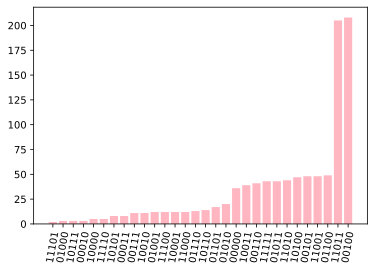


Most frequently sampled bit string is: 00100


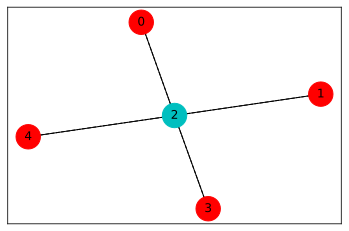

In [24]:
cost, counts, most_freq_bit = maxcut(g, maxiter=50, p=2)

In [1]:
# TO-DOs

# 1. try on real hardware
# 2. Drawing the circuit
# 3. assertions
# 4. extra imports?
# 5. comments?